###  House Prices: Advanced Regression Techniques
#### Competition Description
Ask a home buyer to describe their dream house, and they probably won't begin with the height of the basement ceiling or the proximity to an east-west railroad. But this playground competition's dataset proves that much more influences price negotiations than the number of bedrooms or a white-picket fence.

With 79 explanatory variables describing (almost) every aspect of residential homes in Ames, Iowa, this competition challenges you to predict the final price of each home.
#### Practice Skills
Creative feature engineering 
Advanced regression techniques like random forest and gradient boosting

#### Acknowledgments
The Ames Housing dataset was compiled by Dean De Cock for use in data science education. It's an incredible alternative for data scientists looking for a modernized and expanded version of the often cited Boston Housing dataset. 

### 1.Prepare Problem
#### a.Load libraries
#### b.Load dataset
##### for this problem we will be loading training set and test  from two files as given by kaggle 

In [1]:
import os
import math
import datetime
from mlsettings.settings import load_app_config, get_datafolder_path
from mltools.mlcommon import (detect_outliers,one_hot_dataframe)
from datatools.dfloader import DataFrameLoader
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV
from datatools.customtransformers import LogTransformer,BoxcoxTransformer

import warnings
warnings.filterwarnings('ignore')
% matplotlib inline 
from numpy import set_printoptions
set_printoptions(precision=4)

pd.set_option('display.width', 200)
pd.set_option('precision', 4)
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 200)
pd.set_option('display.notebook_repr_html', True)
sns.set_style("whitegrid")
flatui = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"]
sns.set_palette(flatui)
#colors = ["windows blue", "amber", "greyish", "faded green", "dusty purple"]

#sns.set_palette(sns.color_palette(colors))

#### Helper functions defined 

In [2]:
def plot_dataset(dataset,features ,response_column,log=False):
    fig = plt.figure(figsize=(12,8),dpi=200)

   
    for subplot_index ,i in enumerate(range(0,len(features))):
        if(features[i] != response_column ):
            ax = fig.add_subplot(3, 4,  subplot_index + 1)
            if log:
                ax.set(xscale="log",yscale ="log")
            #ax.scatter(X.iloc[:,i],np.log1p(y),marker=".")
            sns.regplot(x=features[i],y= response_column , marker="+", data = dataset,ax=ax)
            sns.despine()
            ax.set_title("{0} vs {1}".format(features[i],response_column))
            plt.tight_layout()
 
    plt.show()

In [3]:
def check_null(dataset):
    null_sum = dataset.isnull().sum()[dataset.isnull().sum()>0] 
    print("<{0} {1} {0}>".format("="*35,"Dataset null value count"))
    print(null_sum.sort_values(ascending=False))

In [4]:
from sklearn.model_selection import validation_curve
def plot_validation_curve(parameter_values, train_scores, validation_scores):
    plt.figure()
    plt.title("Validation Curve")
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    validation_scores_mean = np.mean(validation_scores, axis=1)
    validation_scores_std = np.std(validation_scores, axis=1)

    plt.fill_between(parameter_values, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(parameter_values, validation_scores_mean - validation_scores_std,
                     validation_scores_mean + validation_scores_std, alpha=0.1, color="g")
    plt.plot(parameter_values, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(parameter_values, validation_scores_mean, 'o-', color="g",
             label="Cross-validation score")
    plt.ylim(validation_scores_mean.min() - .1, train_scores_mean.max() + .1)
    plt.legend(loc="best")
    plt.show()

from sklearn.model_selection import learning_curve
def plot_learning_curve(train_sizes, train_scores, validation_scores):
    plt.figure()
    plt.title("Learning Curve")
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    validation_scores_mean = np.mean(validation_scores, axis=1)
    validation_scores_std = np.std(validation_scores, axis=1)

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, validation_scores_mean - validation_scores_std,
                     validation_scores_mean + validation_scores_std, alpha=0.1, color="g")
    
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",label="Training score")
    plt.plot(train_sizes, validation_scores_mean, 'o-', color="g" ,label="Cross-validation score")
    plt.ylim(max(-3, validation_scores_mean.min() - .1), train_scores_mean.max() + .1)
    plt.legend(loc="best")
    plt.show()

def rmsle(y, y_,convertExp=True):
    if convertExp:
        y = np.exp(y),
        y_ = np.exp(y_)
    log1 = np.nan_to_num(np.array([np.log(v + 1) for v in y]))
    log2 = np.nan_to_num(np.array([np.log(v + 1) for v in y_]))
    calc = (log1 - log2) ** 2
    return np.sqrt(np.mean(calc))

---
#### Mainline

In [5]:
load_app_config()
DIRECTORY="kaggle_housing"
TRAIN_FILE ='train.csv'
TEST_FILE = 'test.csv'
RESPONSE = 'SalePrice'
input_path = get_datafolder_path()
train_file = os.path.join(input_path, DIRECTORY, TRAIN_FILE)
test_file = os.path.join(input_path, DIRECTORY, TEST_FILE)
print(train_file)
print(test_file)
train_loader = DataFrameLoader(train_file, sep=',',header=0 ,encoding='utf8')
test_loader  = DataFrameLoader(test_file, sep=',',header=0 ,encoding='utf8')
X_train =train_loader.dataframe 
y_train =train_loader.dataframe[[RESPONSE]]
X_test = test_loader.dataframe 
# Default continuous and categorical features
X_train_continuous = train_loader.continuous_dataframe
X_test_continuous = test_loader.continuous_dataframe
X_train_categorical = train_loader.categorical_dataframe
X_test_categorical = test_loader.categorical_dataframe
print(X_train.shape)
print(X_test.shape)

Adding D:\DataSource  to system path
Adding D:\MachineLearning  to system path
D:\DataSource\kaggle_housing\train.csv
D:\DataSource\kaggle_housing\test.csv
(1460, 81)
(1459, 80)


In [6]:
ordinal_category =['OverallQual','OverallCond','YearBuilt','YearRemodAdd','GarageYrBlt','MoSold','YrSold','MSSubClass',]

In [7]:
continuous_features = [ feature for feature in train_loader.continuous_features if feature not in ordinal_category]
categorical_features = train_loader.categorical_features
categorical_features.extend(ordinal_category)
continuous_features  =[feature for feature in continuous_features if feature not in [RESPONSE]]

In [8]:
print("size of categorical features :{}".format(len(categorical_features)))
print("size of continuous  features :{}".format(len(continuous_features)))

X_train_continuous = train_loader.dataframe[continuous_features]
print("Checking null in training dataset")
check_null(X_train_continuous)
X_test_continuous = test_loader.dataframe[continuous_features]
print("Checking null in test dataset")
check_null(X_test_continuous)
X_train[continuous_features].head()

size of categorical features :51
size of continuous  features :29
Checking null in training dataset
<=================================== Dataset null value count ===================================>
LotFrontage    259
MasVnrArea       8
dtype: int64
Checking null in test dataset
<=================================== Dataset null value count ===================================>
LotFrontage     227
MasVnrArea       15
BsmtHalfBath      2
BsmtFullBath      2
GarageArea        1
GarageCars        1
TotalBsmtSF       1
BsmtUnfSF         1
BsmtFinSF2        1
BsmtFinSF1        1
dtype: int64


,Id,LotFrontage,LotArea,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal
0,1,65.0,8450,196.0,706,0,150,856,856,854,0,1710,1,0,2,1,3,1,8,0,2,548,0,61,0,0,0,0,0
1,2,80.0,9600,0.0,978,0,284,1262,1262,0,0,1262,0,1,2,0,3,1,6,1,2,460,298,0,0,0,0,0,0
2,3,68.0,11250,162.0,486,0,434,920,920,866,0,1786,1,0,2,1,3,1,6,1,2,608,0,42,0,0,0,0,0
3,4,60.0,9550,0.0,216,0,540,756,961,756,0,1717,1,0,1,0,3,1,7,1,3,642,0,35,272,0,0,0,0
4,5,84.0,14260,350.0,655,0,490,1145,1145,1053,0,2198,1,0,2,1,4,1,9,1,3,836,192,84,0,0,0,0,0


In [9]:
check_null(X_train[categorical_features])
check_null(X_test[categorical_features])

<=================================== Dataset null value count ===================================>
PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
FireplaceQu      690
GarageQual        81
GarageFinish      81
GarageType        81
GarageCond        81
GarageYrBlt       81
BsmtFinType2      38
BsmtExposure      38
BsmtFinType1      37
BsmtCond          37
BsmtQual          37
MasVnrType         8
Electrical         1
dtype: int64
<=================================== Dataset null value count ===================================>
PoolQC          1456
MiscFeature     1408
Alley           1352
Fence           1169
FireplaceQu      730
GarageYrBlt       78
GarageCond        78
GarageQual        78
GarageFinish      78
GarageType        76
BsmtCond          45
BsmtQual          44
BsmtExposure      44
BsmtFinType2      42
BsmtFinType1      42
MasVnrType        16
MSZoning           4
Utilities          2
Functional         2
SaleType           1
Exterior2nd 

---
### Cleaning Datasets
#### Identifying missing values in data
#### Imputing (filling in) these missing values
#### Normalizing/standardizing data
---

In [10]:
NA_mapping ={'PoolQC':'No Pool','MiscFeature':'No MiscFeature','Alley':'No Alley',
'Fence':'No Fence','FireplaceQu':'No Fireplace ','GarageYrBlt':-1,
'GarageCond':'No Garage','GarageQual':'No Garage','GarageFinish':'No Garage',
'GarageType':'No Garage','BsmtCond':'No Basement','BsmtQual':'No Basement',
'BsmtExposure':'No Basement','BsmtFinType2':'No Basement','BsmtFinType1':'No Basement' ,
'MasVnrType':'None'
}

for feature in NA_mapping.keys():
    default_value  = NA_mapping.get(feature)
    X_train[feature].fillna(default_value,inplace = True)
    X_test[feature].fillna(default_value,inplace = True)

check_null(X_train[categorical_features])
check_null(X_test[categorical_features])



<=================================== Dataset null value count ===================================>
Electrical    1
dtype: int64
<=================================== Dataset null value count ===================================>
MSZoning       4
Functional     2
Utilities      2
SaleType       1
KitchenQual    1
Exterior2nd    1
Exterior1st    1
dtype: int64


In [11]:
X_train[X_train['Electrical'].isnull()]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
1379,1380,80,RL,73.0,9735,Pave,No Alley,Reg,Lvl,AllPub,Inside,Gtl,Timber,Norm,Norm,1Fam,SLvl,5,5,2006,2007,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,Unf,0,Unf,0,384,384,GasA,Gd,Y,NaN,754,640,0,1394,0,0,2,1,3,1,Gd,7,Typ,0,No Fireplace,BuiltIn,2007.0,Fin,2,400,TA,TA,Y,100,0,0,0,0,0,No Pool,No Fence,No MiscFeature,0,5,2008,WD,Normal,167500


In [12]:
X_test[X_test['MSZoning'].isnull()]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
455,1916,30,NaN,109.0,21780,Grvl,No Alley,Reg,Lvl,NaN,Inside,Gtl,IDOTRR,Norm,Norm,1Fam,1Story,2,4,1910,1950,Gable,CompShg,Wd Sdng,Wd Sdng,None,0.0,Fa,Fa,CBlock,No Basement,No Basement,No Basement,No Basement,0.0,No Basement,0.0,0.0,0.0,GasA,TA,N,FuseA,810,0,0,810,0.0,0.0,1,0,1,1,TA,4,Min1,0,No Fireplace,Detchd,1975.0,Unf,1.0,280.0,TA,TA,N,119,24,0,0,0,0,No Pool,No Fence,No MiscFeature,0,3,2009,ConLD,Normal
756,2217,20,NaN,80.0,14584,Pave,No Alley,Reg,Low,AllPub,Inside,Mod,IDOTRR,Norm,Norm,1Fam,1Story,1,5,1952,1952,Gable,CompShg,AsbShng,VinylSd,None,0.0,Fa,Po,Slab,No Basement,No Basement,No Basement,No Basement,0.0,No Basement,0.0,0.0,0.0,Wall,Po,N,FuseA,733,0,0,733,0.0,0.0,1,0,2,1,Fa,4,NaN,0,No Fireplace,Attchd,1952.0,Unf,2.0,487.0,Fa,Po,N,0,0,0,0,0,0,No Pool,No Fence,No MiscFeature,0,2,2008,WD,Abnorml
790,2251,70,NaN,NaN,56600,Pave,No Alley,IR1,Low,AllPub,Inside,Gtl,IDOTRR,Norm,Norm,1Fam,2.5Unf,5,1,1900,1950,Hip,CompShg,Wd Sdng,Wd Sdng,None,0.0,TA,TA,BrkTil,TA,TA,No,Unf,0.0,Unf,0.0,686.0,686.0,GasA,Ex,Y,SBrkr,1150,686,0,1836,0.0,0.0,2,0,4,1,TA,7,Maj1,0,No Fireplace,Detchd,1900.0,Unf,1.0,288.0,TA,Fa,N,0,0,0,0,0,0,No Pool,No Fence,No MiscFeature,0,1,2008,WD,Normal
1444,2905,20,NaN,125.0,31250,Pave,No Alley,Reg,Lvl,AllPub,Inside,Gtl,Mitchel,Artery,Norm,1Fam,1Story,1,3,1951,1951,Gable,CompShg,CBlock,VinylSd,None,0.0,TA,Fa,CBlock,No Basement,No Basement,No Basement,No Basement,0.0,No Basement,0.0,0.0,0.0,GasA,TA,Y,FuseA,1600,0,0,1600,0.0,0.0,1,1,3,1,TA,6,Mod,0,No Fireplace,Attchd,1951.0,Unf,1.0,270.0,Fa,TA,N,0,0,135,0,0,0,No Pool,No Fence,No MiscFeature,0,5,2006,WD,Normal


#### Imputing Electrical and Functional

In [13]:
print(X_test[X_test['Neighborhood'] == 'IDOTRR']['MSZoning'].value_counts()) 
X_train['Neighborhood'].fillna('RM',inplace = True)
print(X_train[X_train['Neighborhood'] == 'IDOTRR']['MSZoning'].value_counts())
X_train['Neighborhood'].fillna('RM',inplace = True)

### Timber neighborhood has SBrkr as electrical system.
print(X_train[X_train['Neighborhood'] == 'Timber']['Electrical'].value_counts()) 
X_train['Electrical'].fillna('SBrkr',inplace = True)
print(X_train[X_train['Neighborhood'] == 'IDOTRR']['Functional'].value_counts()) 
print(X_test[X_test['Neighborhood'] == 'IDOTRR']['Functional'].value_counts()) 
X_test['Functional'].fillna('Typ',inplace = True)


RM         40
C (all)    13
Name: MSZoning, dtype: int64
RM         28
C (all)     9
Name: MSZoning, dtype: int64
SBrkr    36
FuseA     1
Name: Electrical, dtype: int64
Typ     35
Maj2     1
Mod      1
Name: Functional, dtype: int64
Typ     44
Min1     3
Min2     3
Mod      2
Maj1     1
Maj2     1
Name: Functional, dtype: int64


#### Imputing Utilities

In [14]:
X_test[X_test['Utilities'].isnull()]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
455,1916,30,NaN,109.0,21780,Grvl,No Alley,Reg,Lvl,NaN,Inside,Gtl,IDOTRR,Norm,Norm,1Fam,1Story,2,4,1910,1950,Gable,CompShg,Wd Sdng,Wd Sdng,None,0.0,Fa,Fa,CBlock,No Basement,No Basement,No Basement,No Basement,0.0,No Basement,0.0,0.0,0.0,GasA,TA,N,FuseA,810,0,0,810,0.0,0.0,1,0,1,1,TA,4,Min1,0,No Fireplace,Detchd,1975.0,Unf,1.0,280.0,TA,TA,N,119,24,0,0,0,0,No Pool,No Fence,No MiscFeature,0,3,2009,ConLD,Normal
485,1946,20,RL,NaN,31220,Pave,No Alley,IR1,Bnk,NaN,FR2,Gtl,Gilbert,Feedr,Norm,1Fam,1Story,6,2,1952,1952,Hip,CompShg,BrkFace,BrkFace,None,0.0,TA,TA,CBlock,TA,TA,No,Unf,0.0,Unf,0.0,1632.0,1632.0,GasA,TA,Y,FuseA,1474,0,0,1474,0.0,0.0,1,0,3,1,TA,7,Min2,2,Gd,Attchd,1952.0,Unf,2.0,495.0,TA,TA,Y,0,0,144,0,0,0,No Pool,No Fence,Shed,750,5,2008,WD,Normal


In [15]:
print(X_train[X_train['Neighborhood'] == 'IDOTRR']['Utilities'].value_counts()) 
print(X_test[X_test['Neighborhood'] == 'IDOTRR']['Utilities'].value_counts())
print(X_train[X_train['Neighborhood'] == 'Gilbert']['Utilities'].value_counts()) 
print(X_test[X_test['Neighborhood'] == 'Gilbert']['Utilities'].value_counts())
X_test[X_test['Utilities'].isnull()]
X_test['Utilities'].fillna('AllPub',inplace = True)

AllPub    37
Name: Utilities, dtype: int64
AllPub    55
Name: Utilities, dtype: int64
AllPub    79
Name: Utilities, dtype: int64
AllPub    85
Name: Utilities, dtype: int64


#### Imputing SaleType

In [16]:
X_test[X_test['SaleType'].isnull()]


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
1029,2490,20,RL,85.0,13770,Pave,No Alley,Reg,Lvl,AllPub,Corner,Gtl,Sawyer,Feedr,Norm,1Fam,1Story,5,6,1958,1998,Gable,CompShg,Plywood,Plywood,BrkFace,340.0,TA,TA,CBlock,TA,TA,Mn,Rec,190.0,BLQ,873.0,95.0,1158.0,GasA,TA,Y,SBrkr,1176,0,0,1176,1.0,0.0,1,0,3,1,TA,6,Typ,2,Gd,Attchd,1958.0,Unf,1.0,303.0,TA,TA,Y,0,0,0,0,0,0,No Pool,No Fence,No MiscFeature,0,10,2007,NaN,Normal


In [17]:
print(X_test[X_test['Neighborhood'] == 'Sawyer']['SaleType'].value_counts())
X_test['SaleType'].fillna('WD',inplace = True)

WD     72
COD     3
Oth     1
Name: SaleType, dtype: int64


#### Imputing SaleType

In [18]:
X_test[X_test['KitchenQual'].isnull()]


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
95,1556,50,RL,72.0,10632,Pave,No Alley,IR1,Lvl,AllPub,Inside,Gtl,ClearCr,Norm,Norm,1Fam,1.5Fin,5,3,1917,1950,Gable,CompShg,Wd Sdng,Wd Sdng,None,0.0,TA,TA,BrkTil,Gd,Fa,No,Unf,0.0,Unf,0.0,689.0,689.0,GasA,Gd,N,SBrkr,725,499,0,1224,0.0,0.0,1,1,3,1,NaN,6,Mod,0,No Fireplace,Detchd,1917.0,Unf,1.0,180.0,Fa,Fa,N,0,0,248,0,0,0,No Pool,No Fence,No MiscFeature,0,1,2010,COD,Normal


In [19]:
print(X_test[X_test['Neighborhood'] == 'ClearCr']['KitchenQual'].value_counts())
print(X_train[X_train['Neighborhood'] == 'ClearCr']['KitchenQual'].value_counts())
X_test['KitchenQual'].fillna('TA',inplace = True)

TA    10
Gd     5
Name: KitchenQual, dtype: int64
TA    14
Gd    12
Ex     2
Name: KitchenQual, dtype: int64


In [20]:
X_test[X_test['Exterior1st'].isnull()]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
691,2152,30,RL,85.0,19550,Pave,No Alley,Reg,Lvl,AllPub,Inside,Gtl,Edwards,Norm,Norm,1Fam,1Story,5,7,1940,2007,Flat,Tar&Grv,NaN,NaN,None,0.0,TA,TA,PConc,TA,TA,Gd,ALQ,1035.0,Unf,0.0,545.0,1580.0,GasA,Ex,Y,SBrkr,1518,0,0,1518,1.0,0.0,1,0,2,1,Fa,5,Typ,2,Gd,No Garage,-1.0,No Garage,0.0,0.0,No Garage,No Garage,Y,0,39,0,0,0,0,No Pool,No Fence,No MiscFeature,0,1,2008,WD,Normal


In [21]:
X_test[X_test['Exterior2nd'].isnull()]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
691,2152,30,RL,85.0,19550,Pave,No Alley,Reg,Lvl,AllPub,Inside,Gtl,Edwards,Norm,Norm,1Fam,1Story,5,7,1940,2007,Flat,Tar&Grv,NaN,NaN,None,0.0,TA,TA,PConc,TA,TA,Gd,ALQ,1035.0,Unf,0.0,545.0,1580.0,GasA,Ex,Y,SBrkr,1518,0,0,1518,1.0,0.0,1,0,2,1,Fa,5,Typ,2,Gd,No Garage,-1.0,No Garage,0.0,0.0,No Garage,No Garage,Y,0,39,0,0,0,0,No Pool,No Fence,No MiscFeature,0,1,2008,WD,Normal


In [22]:
X_test[ (X_test['Neighborhood'] == 'Edwards') & 
        (X_test['RoofStyle'] == 'Flat') ][ ['Exterior1st','Exterior2nd']]

,Exterior1st,Exterior2nd
691,NaN,NaN
1399,Plywood,Wd Shng


In [23]:
X_train[ (X_train['Neighborhood'] == 'Edwards') & 
                    (X_train['RoofStyle'] == 'Flat')&
                    (X_train['HouseStyle'] == '1Story')][ ['Exterior1st','Exterior2nd']]

,Exterior1st,Exterior2nd
1000,BrkComm,Brk Cmn


In [24]:
X_test[X_test['Exterior1st'].isnull()]
X_test['Exterior1st'].fillna('BrkComm',inplace = True)
X_test['Exterior2nd'].fillna('Brk Cmn',inplace = True)

In [25]:
X_test_categorical[X_test_categorical['MSZoning'].isnull()]

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,Heating,HeatingQC,CentralAir,Electrical,KitchenQual,Functional,FireplaceQu,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
455,NaN,Grvl,NaN,Reg,Lvl,NaN,Inside,Gtl,IDOTRR,Norm,Norm,1Fam,1Story,Gable,CompShg,Wd Sdng,Wd Sdng,None,Fa,Fa,CBlock,NaN,NaN,NaN,NaN,NaN,GasA,TA,N,FuseA,TA,Min1,NaN,Detchd,Unf,TA,TA,N,NaN,NaN,NaN,ConLD,Normal
756,NaN,Pave,NaN,Reg,Low,AllPub,Inside,Mod,IDOTRR,Norm,Norm,1Fam,1Story,Gable,CompShg,AsbShng,VinylSd,None,Fa,Po,Slab,NaN,NaN,NaN,NaN,NaN,Wall,Po,N,FuseA,Fa,NaN,NaN,Attchd,Unf,Fa,Po,N,NaN,NaN,NaN,WD,Abnorml
790,NaN,Pave,NaN,IR1,Low,AllPub,Inside,Gtl,IDOTRR,Norm,Norm,1Fam,2.5Unf,Hip,CompShg,Wd Sdng,Wd Sdng,None,TA,TA,BrkTil,TA,TA,No,Unf,Unf,GasA,Ex,Y,SBrkr,TA,Maj1,NaN,Detchd,Unf,TA,Fa,N,NaN,NaN,NaN,WD,Normal
1444,NaN,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Mitchel,Artery,Norm,1Fam,1Story,Gable,CompShg,CBlock,VinylSd,None,TA,Fa,CBlock,NaN,NaN,NaN,NaN,NaN,GasA,TA,Y,FuseA,TA,Mod,NaN,Attchd,Unf,Fa,TA,N,NaN,NaN,NaN,WD,Normal


In [26]:
### considered neighborhood ,MSSubClass
X_test.loc[455,'MSZoning'] = 'RM'
X_test.loc[756,'MSZoning'] = 'C (all)'
X_test.loc[790,'MSZoning'] = 'RM'
X_test.loc[1444,'MSZoning'] = 'RL'

In [27]:
check_null(X_train)
check_null(X_test)

<=================================== Dataset null value count ===================================>
LotFrontage    259
MasVnrArea       8
dtype: int64
<=================================== Dataset null value count ===================================>
LotFrontage     227
MasVnrArea       15
BsmtHalfBath      2
BsmtFullBath      2
GarageArea        1
GarageCars        1
TotalBsmtSF       1
BsmtUnfSF         1
BsmtFinSF2        1
BsmtFinSF1        1
dtype: int64


In [28]:
X_train.drop(X_train[X_train.GrLivArea >= 4000].index, inplace=True)

In [29]:
full_dataset =pd.concat(objs=[X_train, X_test], axis=0,sort =True).reset_index(drop=True)  

In [30]:
full_dataset.head()

,1stFlrSF,2ndFlrSF,3SsnPorch,Alley,BedroomAbvGr,BldgType,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,BsmtFinType1,BsmtFinType2,BsmtFullBath,BsmtHalfBath,BsmtQual,BsmtUnfSF,CentralAir,Condition1,Condition2,Electrical,EnclosedPorch,ExterCond,ExterQual,Exterior1st,Exterior2nd,Fence,FireplaceQu,Fireplaces,Foundation,FullBath,Functional,GarageArea,GarageCars,GarageCond,GarageFinish,GarageQual,GarageType,GarageYrBlt,GrLivArea,HalfBath,Heating,HeatingQC,HouseStyle,Id,KitchenAbvGr,KitchenQual,LandContour,LandSlope,LotArea,LotConfig,LotFrontage,LotShape,LowQualFinSF,MSSubClass,MSZoning,MasVnrArea,MasVnrType,MiscFeature,MiscVal,MoSold,Neighborhood,OpenPorchSF,OverallCond,OverallQual,PavedDrive,PoolArea,PoolQC,RoofMatl,RoofStyle,SaleCondition,SalePrice,SaleType,ScreenPorch,Street,TotRmsAbvGrd,TotalBsmtSF,Utilities,WoodDeckSF,YearBuilt,YearRemodAdd,YrSold
0,856,854,0,No Alley,3,1Fam,TA,No,706.0,0.0,GLQ,Unf,1.0,0.0,Gd,150.0,Y,Norm,Norm,SBrkr,0,TA,Gd,VinylSd,VinylSd,No Fence,No Fireplace,0,PConc,2,Typ,548.0,2.0,TA,RFn,TA,Attchd,2003.0,1710,1,GasA,Ex,2Story,1,1,Gd,Lvl,Gtl,8450,Inside,65.0,Reg,0,60,RL,196.0,BrkFace,No MiscFeature,0,2,CollgCr,61,5,7,Y,0,No Pool,CompShg,Gable,Normal,208500.0,WD,0,Pave,8,856.0,AllPub,0,2003,2003,2008
1,1262,0,0,No Alley,3,1Fam,TA,Gd,978.0,0.0,ALQ,Unf,0.0,1.0,Gd,284.0,Y,Feedr,Norm,SBrkr,0,TA,TA,MetalSd,MetalSd,No Fence,TA,1,CBlock,2,Typ,460.0,2.0,TA,RFn,TA,Attchd,1976.0,1262,0,GasA,Ex,1Story,2,1,TA,Lvl,Gtl,9600,FR2,80.0,Reg,0,20,RL,0.0,None,No MiscFeature,0,5,Veenker,0,8,6,Y,0,No Pool,CompShg,Gable,Normal,181500.0,WD,0,Pave,6,1262.0,AllPub,298,1976,1976,2007
2,920,866,0,No Alley,3,1Fam,TA,Mn,486.0,0.0,GLQ,Unf,1.0,0.0,Gd,434.0,Y,Norm,Norm,SBrkr,0,TA,Gd,VinylSd,VinylSd,No Fence,TA,1,PConc,2,Typ,608.0,2.0,TA,RFn,TA,Attchd,2001.0,1786,1,GasA,Ex,2Story,3,1,Gd,Lvl,Gtl,11250,Inside,68.0,IR1,0,60,RL,162.0,BrkFace,No MiscFeature,0,9,CollgCr,42,5,7,Y,0,No Pool,CompShg,Gable,Normal,223500.0,WD,0,Pave,6,920.0,AllPub,0,2001,2002,2008
3,961,756,0,No Alley,3,1Fam,Gd,No,216.0,0.0,ALQ,Unf,1.0,0.0,TA,540.0,Y,Norm,Norm,SBrkr,272,TA,TA,Wd Sdng,Wd Shng,No Fence,Gd,1,BrkTil,1,Typ,642.0,3.0,TA,Unf,TA,Detchd,1998.0,1717,0,GasA,Gd,2Story,4,1,Gd,Lvl,Gtl,9550,Corner,60.0,IR1,0,70,RL,0.0,None,No MiscFeature,0,2,Crawfor,35,5,7,Y,0,No Pool,CompShg,Gable,Abnorml,140000.0,WD,0,Pave,7,756.0,AllPub,0,1915,1970,2006
4,1145,1053,0,No Alley,4,1Fam,TA,Av,655.0,0.0,GLQ,Unf,1.0,0.0,Gd,490.0,Y,Norm,Norm,SBrkr,0,TA,Gd,VinylSd,VinylSd,No Fence,TA,1,PConc,2,Typ,836.0,3.0,TA,RFn,TA,Attchd,2000.0,2198,1,GasA,Ex,2Story,5,1,Gd,Lvl,Gtl,14260,FR2,84.0,IR1,0,60,RL,350.0,BrkFace,No MiscFeature,0,12,NoRidge,84,5,8,Y,0,No Pool,CompShg,Gable,Normal,250000.0,WD,0,Pave,9,1145.0,AllPub,192,2000,2000,2008


In [31]:
full_dataset['BsmtHalfBath'].fillna(0,inplace=True)
full_dataset['BsmtFullBath'].fillna(0,inplace=True)
full_dataset['TotalBsmtSF'].fillna(0,inplace=True)
full_dataset['BsmtUnfSF'].fillna(0,inplace=True)
full_dataset['BsmtFinSF2'].fillna(0,inplace=True)
full_dataset['TotalBsmtSF'].fillna(0,inplace=True)
full_dataset['BsmtFinSF1'].fillna(0,inplace=True)
full_dataset['GarageArea'].fillna(0,inplace=True)
full_dataset['GarageCars'].fillna(0,inplace=True)
full_dataset["MasVnrArea"].fillna(0, inplace=True)

In [32]:
lot_frontage_by_neighborhood = X_train['LotFrontage'].groupby(X_train['Neighborhood'])
for key, group in lot_frontage_by_neighborhood:
    idx = (full_dataset['Neighborhood'] == key) & (full_dataset['LotFrontage'].isnull())
    full_dataset.loc[idx, 'LotFrontage'] = group.median()

In [33]:
check_null(full_dataset)

<=================================== Dataset null value count ===================================>
SalePrice    1459
dtype: int64


In [34]:
full_dataset['ExterQual'] = full_dataset['ExterQual'].str.upper().str.strip()
full_dataset['ExterCond'] =full_dataset['ExterCond'].str.upper().str.strip()
full_dataset['KitchenQual'] = full_dataset['KitchenQual'].str.upper().str.strip()
full_dataset['FireplaceQu'] =full_dataset['FireplaceQu'].str.upper().str.strip()
full_dataset['GarageQual'] =full_dataset['GarageQual'].str.upper().str.strip()
full_dataset['GarageCond']=full_dataset['GarageCond'].str.upper().str.strip()

full_dataset['PoolQC'] = full_dataset['PoolQC'].str.upper().str.strip()
full_dataset['BsmtQual'] =full_dataset['BsmtQual'].str.upper().str.strip()
full_dataset['BsmtCond'] =full_dataset['BsmtCond'].str.upper().str.strip()
full_dataset['HeatingQC'] =full_dataset['HeatingQC'].str.upper().str.strip()
full_dataset['BsmtFinType1'] =full_dataset['BsmtFinType1'].str.upper().str.strip()
full_dataset['BsmtFinType2'] =full_dataset['BsmtFinType2'].str.upper().str.strip()
external_quality = full_dataset['ExterQual'].unique().tolist()
print(external_quality)
external_condition = full_dataset['ExterCond'].unique().tolist()
print(external_condition)
kitchen_quality = full_dataset['KitchenQual'].unique().tolist() 
print(kitchen_quality)
fireplace_quality = full_dataset['FireplaceQu'].unique().tolist()
print(fireplace_quality)
garage_quality =  full_dataset['GarageQual'].unique().tolist()
print(garage_quality)
garage_condition=  full_dataset['GarageCond'].unique().tolist()
print(garage_condition)
pool_quality =  full_dataset['PoolQC'].unique().tolist()
print(pool_quality)
basement_quality = full_dataset['BsmtQual'].unique().tolist()
print(basement_quality)
basement_condition = full_dataset['BsmtCond'].unique().tolist()
print(basement_condition)
heating_quality = full_dataset['HeatingQC'].unique().tolist()
print(heating_quality)
basement_finish_type1 = sorted(full_dataset['BsmtFinType1'].unique().tolist())
print(basement_finish_type1)
basement_finish_type2 = sorted(full_dataset['BsmtFinType2'].unique().tolist())
print(basement_finish_type2)

['GD', 'TA', 'EX', 'FA']
['TA', 'GD', 'FA', 'PO', 'EX']
['GD', 'TA', 'EX', 'FA']
['NO FIREPLACE', 'TA', 'GD', 'FA', 'EX', 'PO']
['TA', 'FA', 'GD', 'NO GARAGE', 'EX', 'PO']
['TA', 'FA', 'NO GARAGE', 'GD', 'PO', 'EX']
['NO POOL', 'EX', 'FA', 'GD']
['GD', 'TA', 'EX', 'NO BASEMENT', 'FA']
['TA', 'GD', 'NO BASEMENT', 'FA', 'PO']
['EX', 'GD', 'TA', 'FA', 'PO']
['ALQ', 'BLQ', 'GLQ', 'LWQ', 'NO BASEMENT', 'REC', 'UNF']
['ALQ', 'BLQ', 'GLQ', 'LWQ', 'NO BASEMENT', 'REC', 'UNF']


In [35]:
quality_converter = {'NA':0,'NO FIREPLACE':0,'NO POOL':0,'NO BASEMENT':0,'NO GARAGE':0,'PO':1, 'FA':2,'TA':3 ,'GD':4,'EX' :5}
full_dataset['ExterQual'] = full_dataset['ExterQual'].map(quality_converter)
full_dataset['ExterCond'] =full_dataset['ExterCond'].map(quality_converter)
full_dataset['KitchenQual'] = full_dataset['KitchenQual'].map(quality_converter)
full_dataset['FireplaceQu'] =full_dataset['FireplaceQu'].map(quality_converter)
full_dataset['GarageQual'] =full_dataset['GarageQual'].map(quality_converter)
full_dataset['PoolQC'] = full_dataset['PoolQC'].map(quality_converter)
full_dataset['BsmtQual'] =full_dataset['BsmtQual'].map(quality_converter)
full_dataset['BsmtCond'] =full_dataset['BsmtCond'].map(quality_converter)
full_dataset['HeatingQC'] =full_dataset['HeatingQC'].map(quality_converter)
full_dataset['GarageCond'] =full_dataset['GarageCond'].map(quality_converter)

In [36]:
basement_finish_converter ={ 'NO BASEMENT':0,  'UNF':1, 'LWQ':2,'REC':3,'BLQ':4,'ALQ':5,'GLQ':6}
full_dataset['BsmtFinType1'] =full_dataset['BsmtFinType1'].map(basement_finish_converter)
full_dataset['BsmtFinType2'] =full_dataset['BsmtFinType2'].map(basement_finish_converter)

In [37]:
full_dataset["TotalBath"] = full_dataset["FullBath"] + 0.5*full_dataset["HalfBath"] + full_dataset["BsmtFullBath"] + 0.5*full_dataset["BsmtHalfBath"]
full_dataset["TotalArea"] = full_dataset["GrLivArea"] + full_dataset["TotalBsmtSF"]
full_dataset['TotalFloorSF'] = full_dataset['1stFlrSF'] + full_dataset['2ndFlrSF']
full_dataset['TotalBsmtFinSF']  = full_dataset['BsmtFinSF1'] + full_dataset['BsmtFinSF2']


In [38]:
garage_finish_map={'No Garage': 0, "Unf": 1, "RFn": 2, "Fin": 3} 
full_dataset['GarageFinish'] = full_dataset['GarageFinish'].map(garage_finish_map)
ordinal_category.append('GarageFinish')
full_dataset['TotalPorchSF'] = (full_dataset['OpenPorchSF'] + full_dataset['EnclosedPorch'] + 
                               full_dataset['3SsnPorch'] + full_dataset['ScreenPorch'])

In [39]:
full_dataset.drop(["FullBath","HalfBath","BsmtFullBath","BsmtHalfBath"],axis=1,inplace=True)
full_dataset.drop(['1stFlrSF','2ndFlrSF'],axis=1,inplace=True)
full_dataset.drop(['BsmtFinSF1','BsmtFinSF2'],axis=1,inplace=True)
full_dataset.drop(['OpenPorchSF','EnclosedPorch','3SsnPorch','ScreenPorch'],axis=1,inplace=True)
columns_dropped =['1stFlrSF','2ndFlrSF','OpenPorchSF','EnclosedPorch','3SsnPorch','ScreenPorch',
                  'BsmtFullBath' ,'BsmtHalfBath' ,'FullBath', 'HalfBath','BsmtFinSF1','BsmtFinSF2']

In [40]:
final_non_count = [feature for feature in continuous_features if feature not in columns_dropped +['Id','SalePrice','LogSalePrice']]
final_non_count = final_non_count + ['TotalBath','TotalArea','TotalFloorSF','TotalBsmtFinSF','TotalPorchSF']


In [41]:
X = full_dataset[sorted(final_non_count)].skew()
skewness = pd.DataFrame( {'Feature':X.index ,
                          'skew':X.values,
                          'max':full_dataset[sorted(final_non_count)].max(),
                          'min':full_dataset[sorted(final_non_count)].min(),
                         'max_min_ratio':full_dataset[sorted(final_non_count)].max()/(full_dataset[sorted(final_non_count)].min()+1)
                          })

remove_skew =skewness[skewness['skew']>1]['Feature'].values.tolist()
skewness[skewness['skew']>1]

,Feature,skew,max,min,max_min_ratio
KitchenAbvGr,KitchenAbvGr,4.3011,3.0,0.0,3.0000
LotArea,LotArea,13.1305,215245.0,1300.0,165.4458
LotFrontage,LotFrontage,1.0934,313.0,21.0,14.2273
LowQualFinSF,LowQualFinSF,12.0865,1064.0,0.0,1064.0000
MasVnrArea,MasVnrArea,2.6020,1600.0,0.0,1600.0000
MiscVal,MiscVal,21.9434,17000.0,0.0,17000.0000
PoolArea,PoolArea,18.7115,800.0,0.0,800.0000
TotalPorchSF,TotalPorchSF,2.2446,1207.0,0.0,1207.0000
WoodDeckSF,WoodDeckSF,1.8492,1424.0,0.0,1424.0000


In [42]:
remove_skew.remove('KitchenAbvGr')


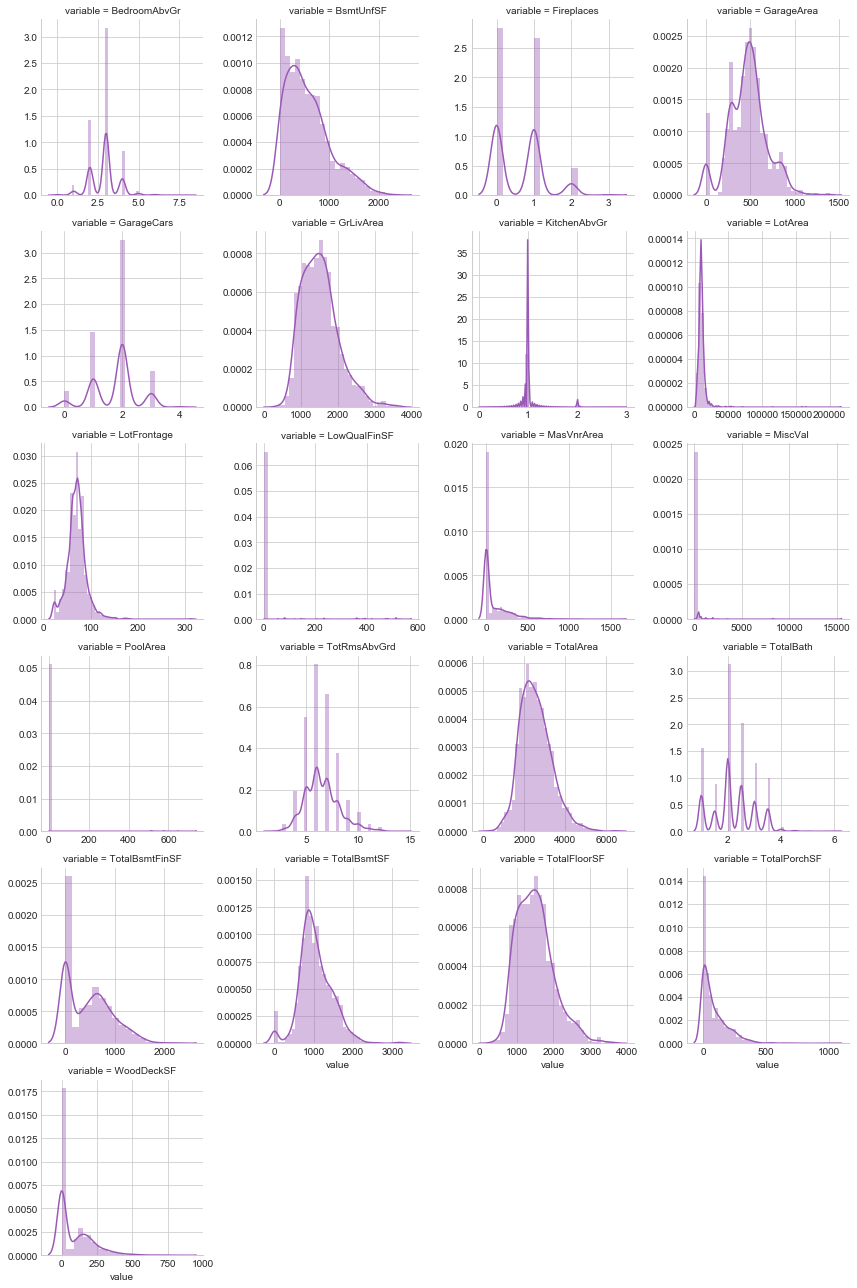

In [43]:
f = pd.melt(full_dataset[full_dataset['SalePrice'].notnull()], value_vars=sorted(final_non_count))
g = sns.FacetGrid(f, col='variable', col_wrap=4, sharex=False, sharey=False)
g = g.map(sns.distplot, 'value')

In [44]:
power_transformed_columns =remove_skew

In [45]:
full_dataset[power_transformed_columns].describe()

,LotArea,LotFrontage,LowQualFinSF,MasVnrArea,MiscVal,PoolArea,TotalPorchSF,WoodDeckSF
count,2915.0000,2915.0000,2915.0000,2915.0000,2915.0000,2915.0000,2915.0000,2915.0000
mean,10133.6487,69.4039,4.7009,100.5993,50.8957,1.8998,89.0889,93.5039
std,7806.1985,21.1348,46.4283,176.9788,567.7884,33.0206,107.7491,126.4551
min,1300.0000,21.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
25%,7474.0000,60.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
50%,9450.0000,70.0000,0.0000,0.0000,0.0000,0.0000,50.0000,0.0000
75%,11554.5000,80.0000,0.0000,162.5000,0.0000,0.0000,136.0000,168.0000
max,215245.0000,313.0000,1064.0000,1600.0000,17000.0000,800.0000,1207.0000,1424.0000


In [46]:
for column in power_transformed_columns:
    full_dataset.loc[(full_dataset[column] == 0),[column]]=0.01

In [47]:
bc_transformer = BoxcoxTransformer(power_transformed_columns) 
full_dataset = bc_transformer.fit_transform(full_dataset)

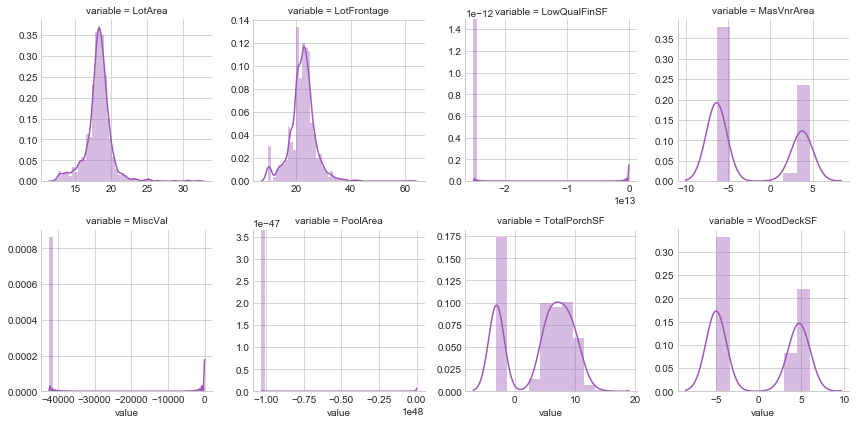

In [48]:
f = pd.melt(full_dataset[full_dataset['SalePrice'].notnull()], value_vars=sorted(power_transformed_columns))
g = sns.FacetGrid(f, col='variable', col_wrap=4, sharex=False, sharey=False)
g = g.map(sns.distplot, 'value')

In [49]:
full_dataset[sorted(power_transformed_columns)].skew()

LotArea          0.1111
LotFrontage      0.1685
LowQualFinSF     8.3643
MasVnrArea       0.4350
MiscVal          5.0362
PoolArea        16.1949
TotalPorchSF    -0.5052
WoodDeckSF       0.1057
dtype: float64

In [50]:
from datatools.customtransformers import StdScaleTransformer,RobustScaleTransformer
rbst_scaler = RobustScaleTransformer(final_non_count)
full_dataset =rbst_scaler.fit_transform(full_dataset)

In [51]:
full_dataset["HighSeason"] = full_dataset["MoSold"].replace({1: 0, 2: 0, 3: 0, 4: 1, 5: 1, 6: 1, 7: 1, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0})
full_dataset["NewerDwelling"] = full_dataset["MSSubClass"].replace({20: 1, 30: 0, 40: 0, 45: 0,50: 0, 60: 1, 70: 0, 75: 0, 80: 0, 85: 0,90: 0, 120: 1, 150: 0, 160: 0, 180: 0, 190: 0})

In [52]:
categorical_features.append('HighSeason')
categorical_features.append('NewerDwelling')

In [53]:
#f = pd.melt(full_dataset[full_dataset['SalePrice'].notnull()], value_vars=sorted(categorical_features))
#g = sns.FacetGrid(f, col='variable', col_wrap=4, sharex=False, sharey=False)
#plt.xticks(rotation='vertical')
#g = g.map(sns.countplot, 'value')
#[plt.setp(ax.get_xticklabels(), rotation=60) for ax in g.axes.flat]
#g.fig.tight_layout()
#plt.show()

In [54]:
cat_data =  full_dataset[full_dataset['SalePrice'].notnull()] [categorical_features+['SalePrice']]

In [55]:
def boxplot(x,y,**kwargs):
    sns.boxplot(x=x,y=y)
    x = plt.xticks(rotation=90)


In [56]:
#p = pd.melt(cat_data, id_vars='SalePrice', value_vars=categorical_features)
#p=p.sort_values(by='variable')
#g = sns.FacetGrid (p, col='variable', col_wrap=2, sharex=False, sharey=False, size=5)
#g = g.map(boxplot, 'value','SalePrice')
#g

<module 'matplotlib.pyplot' from 'D:\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

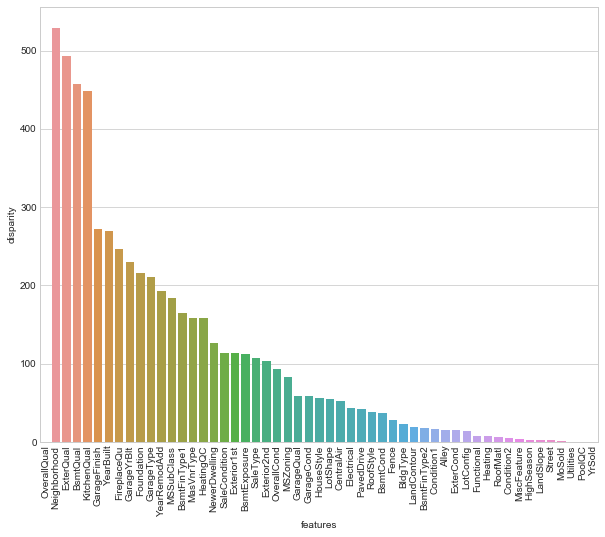

In [57]:
from scipy import stats
def anova(frame):
    anv = pd.DataFrame()
    anv['features'] = categorical_features
    pvals = []
    for c in categorical_features:
        samples = []
        for cls in frame[c].unique():
            s = frame[frame[c] == cls]['SalePrice'].values
            samples.append(s)
        pval = stats.f_oneway(*samples)[1]
        pvals.append(pval)
    anv['pval'] = pvals
    return anv.sort_values('pval')

 
k = anova(cat_data) 
k['disparity'] = np.log(1./k['pval'].values) 

plt.figure(figsize=(10,8))
sns.barplot(data=k, x = 'features', y='disparity') 
plt.xticks(rotation=90) 
plt 

In [58]:


MSZoning_map  ={'C (all)':1,'RM':2,'RH':2, 'RL':3,'FV':3}
Neighborhood_map ={"MeadowV" : 0, "IDOTRR" : 1, "BrDale" : 1, "OldTown" : 1, "Edwards" : 1, "BrkSide" : 1, "Sawyer" : 1, "Blueste" : 1,
                   "SWISU" : 2, "NAmes" : 2, "NPkVill" : 2, "Mitchel" : 2, "SawyerW" : 2, "Gilbert" : 2, "NWAmes" : 2, "Blmngtn" : 2, 
                   "CollgCr" : 2, "ClearCr" : 3, "Crawfor" : 3, "Veenker" : 3, "Somerst" : 3, "Timber" : 3, 
                   "StoneBr" : 4, "NoRidge" : 4, "NridgHt" : 4}
BsmtExposure_map = { 'No Basement':0 ,'No':1,'Mn':2,'Av':3,'Gd':4}
MSSubClass_map = {30:'0',180:'1',45:'1',190:'1',90:'1',150:'1',160:'1',
                  50:'2',85:'2',40:'2',70:'3',80:'3',20:'3',75:'3',120:'3',60:'4'}
SaleCondition_map ={'Abnorml': 1, 'Alloca': 1, 'AdjLand': 1, 'Family': 1, 'Normal': 0, 'Partial': 0}
Fence_map ={'No Fence': 0, "MnWw": 1, "GdWo": 2, "MnPrv": 3, "GdPrv": 4} 
#full_dataset["BldgType_1Fam"] = (full_dataset["BldgType"] == "1Fam") * 1
full_dataset["CentralAir"] = (full_dataset["CentralAir"] == "Y") * 1
full_dataset["IsSaleType=WD"] = (full_dataset["SaleType"] == "WD") * 1
full_dataset['MSZoning_Rank'] =full_dataset['MSZoning'].map(MSZoning_map)
full_dataset['BsmtExposure_Rank'] =full_dataset['BsmtExposure'].map(BsmtExposure_map)
full_dataset['MSSubClass'] =full_dataset['MSSubClass'].map(MSSubClass_map)
full_dataset['Neighborhood_Rank'] =full_dataset['Neighborhood'].map(Neighborhood_map)
full_dataset['SaleCondition_Rank'] =full_dataset['SaleCondition'].map(SaleCondition_map)
full_dataset["Fence_Rank"] = full_dataset["Fence"].map(Fence_map)
full_dataset["RecentRemodel"] = (full_dataset["YearRemodAdd"] == full_dataset["YrSold"]) * 1
full_dataset["VeryNewHouse"] = (full_dataset["YearBuilt"] == full_dataset["YrSold"]) * 1
full_dataset["Age"] = 2010 - full_dataset["YearBuilt"]
full_dataset["TimeSinceSold"] = 2010 - full_dataset["YrSold"]
full_dataset["SeasonSold"] = full_dataset["MoSold"].map({12:0, 1:0, 2:0, 3:1, 4:1, 5:1, 6:2, 7:2, 8:2, 9:3, 10:3, 11:3}).astype(int)
full_dataset["YearsSinceRemodel"] = full_dataset["YrSold"] - full_dataset["YearRemodAdd"]

In [59]:
year_map = pd.concat(pd.Series("YearBin" + str(i+1), index=range(1871+i*20,1891+i*20))  for i in range(0, 7))

In [60]:
full_dataset["YearBuilt_bin"] =full_dataset['YearBuilt'].map(year_map)
full_dataset["YearRemodAdd_bin"] = full_dataset['YearRemodAdd'].map(year_map)
categorical_features.append('YearBuilt_bin')
categorical_features.append('YearRemodAdd_bin')

In [61]:
#drop_category =['RoofMatl','Condition2','MiscFeature','HighSeason','LandSlope',
#                 'Street','MoSold','Utilities','PoolQC','YrSold','Neighborhood',
#                'MSZoning','BsmtExposure','SaleCondition','SaleType','Alley',
#                 'GarageYrBlt','OverallCond','YearBuilt','YearRemodAdd']
#full_dataset.drop(drop_category,axis =1,inplace =True)
#full_dataset.drop(['PoolArea','GrLivArea',],axis =1,inplace =True)

In [62]:
full_dataset[categorical_features].head()

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,Heating,HeatingQC,CentralAir,Electrical,KitchenQual,Functional,FireplaceQu,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition,OverallQual,OverallCond,YearBuilt,YearRemodAdd,GarageYrBlt,MoSold,YrSold,MSSubClass,HighSeason,NewerDwelling,YearBuilt_bin,YearRemodAdd_bin
0,RL,Pave,No Alley,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,BrkFace,4,3,PConc,4,3,No,6,1,GasA,5,1,SBrkr,4,Typ,0,Attchd,2,3,3,Y,0,No Fence,No MiscFeature,WD,Normal,7,5,2003,2003,2003.0,2,2008,4,0,1,YearBin7,YearBin7
1,RL,Pave,No Alley,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,Gable,CompShg,MetalSd,MetalSd,None,3,3,CBlock,4,3,Gd,5,1,GasA,5,1,SBrkr,3,Typ,3,Attchd,2,3,3,Y,0,No Fence,No MiscFeature,WD,Normal,6,8,1976,1976,1976.0,5,2007,3,1,1,YearBin6,YearBin6
2,RL,Pave,No Alley,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,BrkFace,4,3,PConc,4,3,Mn,6,1,GasA,5,1,SBrkr,4,Typ,3,Attchd,2,3,3,Y,0,No Fence,No MiscFeature,WD,Normal,7,5,2001,2002,2001.0,9,2008,4,0,1,YearBin7,YearBin7
3,RL,Pave,No Alley,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,Gable,CompShg,Wd Sdng,Wd Shng,None,3,3,BrkTil,3,4,No,5,1,GasA,4,1,SBrkr,4,Typ,4,Detchd,1,3,3,Y,0,No Fence,No MiscFeature,WD,Abnorml,7,5,1915,1970,1998.0,2,2006,3,0,0,YearBin3,YearBin5
4,RL,Pave,No Alley,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,BrkFace,4,3,PConc,4,3,Av,6,1,GasA,5,1,SBrkr,4,Typ,3,Attchd,2,3,3,Y,0,No Fence,No MiscFeature,WD,Normal,8,5,2000,2000,2000.0,12,2008,4,0,1,YearBin7,YearBin7


In [63]:
test_dataset  =  full_dataset[full_dataset['SalePrice'].isnull()]
test_dataset,test_dataset_ignore = one_hot_dataframe(test_dataset, categorical_features, replace=True)

In [64]:
full_dataset,full_dataset_ignore = one_hot_dataframe(full_dataset, categorical_features, replace=True)

In [65]:
full_columns = full_dataset.columns.values.tolist()
test_columns = test_dataset.columns.values.tolist()
columns_not_matching = set(full_columns) - set(test_columns)
 

In [66]:
train_dataset = full_dataset[full_dataset['SalePrice'].notnull()]
train_dataset.head()

,BedroomAbvGr,BsmtUnfSF,Fireplaces,GarageArea,GarageCars,GrLivArea,Id,KitchenAbvGr,LotArea,LotFrontage,LowQualFinSF,MasVnrArea,MiscVal,PoolArea,SalePrice,TotRmsAbvGrd,TotalBsmtSF,WoodDeckSF,TotalBath,TotalArea,TotalFloorSF,TotalBsmtFinSF,TotalPorchSF,IsSaleType=WD,MSZoning_Rank,BsmtExposure_Rank,Neighborhood_Rank,SaleCondition_Rank,Fence_Rank,RecentRemodel,VeryNewHouse,Age,TimeSinceSold,SeasonSold,YearsSinceRemodel,Alley=Grvl,Alley=No Alley,Alley=Pave,BldgType=1Fam,BldgType=2fmCon,BldgType=Duplex,BldgType=Twnhs,BldgType=TwnhsE,BsmtCond,BsmtExposure=Av,BsmtExposure=Gd,BsmtExposure=Mn,BsmtExposure=No,BsmtExposure=No Basement,BsmtFinType1,BsmtFinType2,BsmtQual,CentralAir,Condition1=Artery,Condition1=Feedr,Condition1=Norm,Condition1=PosA,Condition1=PosN,Condition1=RRAe,Condition1=RRAn,Condition1=RRNe,Condition1=RRNn,Condition2=Artery,Condition2=Feedr,Condition2=Norm,Condition2=PosA,Condition2=PosN,Condition2=RRAe,Condition2=RRAn,Condition2=RRNn,Electrical=FuseA,Electrical=FuseF,Electrical=FuseP,Electrical=Mix,Electrical=SBrkr,ExterCond,ExterQual,Exterior1st=AsbShng,Exterior1st=AsphShn,Exterior1st=BrkComm,Exterior1st=BrkFace,Exterior1st=CBlock,Exterior1st=CemntBd,Exterior1st=HdBoard,Exterior1st=ImStucc,Exterior1st=MetalSd,Exterior1st=Plywood,Exterior1st=Stone,Exterior1st=Stucco,Exterior1st=VinylSd,Exterior1st=Wd Sdng,Exterior1st=WdShing,Exterior2nd=AsbShng,Exterior2nd=AsphShn,Exterior2nd=Brk Cmn,Exterior2nd=BrkFace,Exterior2nd=CBlock,Exterior2nd=CmentBd,Exterior2nd=HdBoard,Exterior2nd=ImStucc,...,LotShape=IR3,LotShape=Reg,MSSubClass=0,MSSubClass=1,MSSubClass=2,MSSubClass=3,MSSubClass=4,MSZoning=C (all),MSZoning=FV,MSZoning=RH,MSZoning=RL,MSZoning=RM,MasVnrType=BrkCmn,MasVnrType=BrkFace,MasVnrType=None,MasVnrType=Stone,MiscFeature=Gar2,MiscFeature=No MiscFeature,MiscFeature=Othr,MiscFeature=Shed,MiscFeature=TenC,MoSold,Neighborhood=Blmngtn,Neighborhood=Blueste,Neighborhood=BrDale,Neighborhood=BrkSide,Neighborhood=ClearCr,Neighborhood=CollgCr,Neighborhood=Crawfor,Neighborhood=Edwards,Neighborhood=Gilbert,Neighborhood=IDOTRR,Neighborhood=MeadowV,Neighborhood=Mitchel,Neighborhood=NAmes,Neighborhood=NPkVill,Neighborhood=NWAmes,Neighborhood=NoRidge,Neighborhood=NridgHt,Neighborhood=OldTown,Neighborhood=SWISU,Neighborhood=Sawyer,Neighborhood=SawyerW,Neighborhood=Somerst,Neighborhood=StoneBr,Neighborhood=Timber,Neighborhood=Veenker,NewerDwelling,OverallCond,OverallQual,PavedDrive=N,PavedDrive=P,PavedDrive=Y,PoolQC,RoofMatl=CompShg,RoofMatl=Membran,RoofMatl=Metal,RoofMatl=Roll,RoofMatl=Tar&Grv,RoofMatl=WdShake,RoofMatl=WdShngl,RoofStyle=Flat,RoofStyle=Gable,RoofStyle=Gambrel,RoofStyle=Hip,RoofStyle=Mansard,RoofStyle=Shed,SaleCondition=Abnorml,SaleCondition=AdjLand,SaleCondition=Alloca,SaleCondition=Family,SaleCondition=Normal,SaleCondition=Partial,SaleType=COD,SaleType=CWD,SaleType=Con,SaleType=ConLD,SaleType=ConLI,SaleType=ConLw,SaleType=New,SaleType=Oth,SaleType=WD,Street=Grvl,Street=Pave,Utilities=AllPub,Utilities=NoSeWa,YearBuilt,YearBuilt_bin=YearBin1,YearBuilt_bin=YearBin2,YearBuilt_bin=YearBin3,YearBuilt_bin=YearBin4,YearBuilt_bin=YearBin5,YearBuilt_bin=YearBin6,YearBuilt_bin=YearBin7,YearRemodAdd,YearRemodAdd_bin=YearBin4,YearRemodAdd_bin=YearBin5,YearRemodAdd_bin=YearBin6,YearRemodAdd_bin=YearBin7,YrSold
0,0.0,-0.5433,-1.0,0.2695,0.0,0.4344,1,0.0,-0.2553,-0.2529,0.0,1.0093,0.0,0.0,208500.0,1.0,-0.2601,0.0000,1.5,0.1153,0.4355,0.3111,0.0392,1,3,1,2,0,0,0,0,7,2,0,5,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,1.0,0.0,6.0,1.0,4.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,5.0,7.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0

In [67]:
full_dataset['LogSalePrice'] = np.log1p(full_dataset['SalePrice'])

In [68]:
train_Id  = full_dataset[full_dataset['SalePrice'].notnull()]["Id"]
test_Id = full_dataset[full_dataset['SalePrice'].isnull()]["Id"]
full_dataset.drop(['Id'],axis=1,inplace=True)
test_columns.remove('Id')


In [69]:
train_X = full_dataset[full_dataset['SalePrice'].notnull()][test_columns]
test_X = full_dataset[full_dataset['SalePrice'].isnull()]  [test_columns]
train_y= full_dataset[full_dataset['LogSalePrice'].notnull()]['LogSalePrice']
train_X.drop(['SalePrice'],axis=1,inplace=True)
test_X.drop(['SalePrice'],axis=1,inplace=True)

In [70]:
check_null(train_X)
check_null(test_X)

<=================================== Dataset null value count ===================================>
Series([], dtype: int64)
<=================================== Dataset null value count ===================================>
Series([], dtype: int64)


In [71]:
from sklearn.model_selection import train_test_split
print(train_X.shape)
print(test_X.shape)
test_size = 0.25
seed = 17
X_trainmodel, X_val, y_trainmodel, y_val = train_test_split(train_X, train_y, test_size=test_size,random_state=seed)

(1456, 252)
(1459, 252)


In [72]:
def best_fit_search(grid,train_X,train_y):
    
    grid.fit(X=train_X,y=train_y)
    print(grid.best_score_)
    print(grid.best_params_)
    best_model =grid.best_estimator_
    best_model.fit(X = X_trainmodel,y = y_trainmodel)
    y_pred_val= best_model.predict(X= X_val)
    print ("RMSLE Value: ",rmsle(np.exp(y_val)-1,np.exp(y_pred_val),False))
    train_sizes, train_scores, validation_scores = learning_curve(best_model, X_trainmodel,y_trainmodel.values.ravel(),cv=5)
    plot_learning_curve(train_sizes, train_scores, validation_scores)
    return best_model

RMSLE Value :  0.29562176216676417


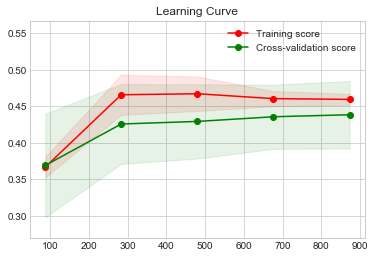

In [73]:
from sklearn.linear_model import ElasticNet
elnet_regr = ElasticNet(random_state=0)
elnet_regr.fit(X = X_trainmodel,y = y_trainmodel)
y_pred_val= elnet_regr.predict(X= X_val)
print ("RMSLE Value : ",rmsle(np.exp(y_val)-1,np.exp(y_pred_val),False))
train_sizes, train_scores, validation_scores = learning_curve(elnet_regr, X_trainmodel,y_trainmodel.values.ravel(),cv=5)
plot_learning_curve(train_sizes, train_scores, validation_scores)

In [74]:
param_grid = {'alpha': np.logspace(-4, -1, 10),
              'l1_ratio': [0.005,0.001, .1, .5],
              'max_iter':[10000]
                 }

#grid = GridSearchCV(estimator=elnet_regr, param_grid=param_grid, n_jobs=-1)
#best_model =best_fit_search(grid,X_trainmodel, y_trainmodel)

In [75]:
#best_model

In [76]:
from sklearn.linear_model import ElasticNetCV
elnet_cv = ElasticNetCV(cv=5, random_state=0,max_iter =10000,alphas= np.logspace(-4, -1, 10),l1_ratio=[0.005,0.001, .1, .5])
print(elnet_cv)
elnet_cv.fit(X_trainmodel, y_trainmodel)
y_pred_val= elnet_cv.predict(X= X_val)
print ("RMSLE Value :",rmsle(np.exp(y_val)-1,np.exp(y_pred_val),False))

ElasticNetCV(alphas=array([0.0001 , 0.00022, 0.00046, 0.001  , 0.00215, 0.00464, 0.01   ,
       0.02154, 0.04642, 0.1    ]),
       copy_X=True, cv=5, eps=0.001, fit_intercept=True,
       l1_ratio=[0.005, 0.001, 0.1, 0.5], max_iter=10000, n_alphas=100,
       n_jobs=1, normalize=False, positive=False, precompute='auto',
       random_state=0, selection='cyclic', tol=0.0001, verbose=0)
RMSLE Value : 0.10989548723389639


In [77]:
print("Number of Iteration:{0}".format(elnet_cv.n_iter_))
print("Alphas computed :{0}".format(elnet_cv.alphas))
y_pred_result = elnet_cv.predict(X=test_X)

Number of Iteration:10000
Alphas computed :[0.0001 0.0002 0.0005 0.001  0.0022 0.0046 0.01   0.0215 0.0464 0.1   ]


In [94]:
#from mlxtend.feature_selection import ExhaustiveFeatureSelector as EFS
#efs = EFS(elnet_cv, 
#          min_features=60,
#          max_features=120,
#          scoring='neg_mean_squared_error',
#          cv=10)

#efs.fit(X_trainmodel, y_trainmodel)

#print('Best MSE score: %.2f' % efs.best_score_ * (-1))
#print('Best subset:', efs.best_idx_)

In [78]:
from sklearn.linear_model import LassoCV
lcv = LassoCV(eps=0.01, n_alphas=100, alphas= np.logspace(-4, -1, 10), fit_intercept=True, 
               normalize=True, precompute='auto', max_iter=1000, tol=0.001)
print(lcv)
lcv.fit(X_trainmodel, y_trainmodel)
y_pred_val= lcv.predict(X= X_val)
print ("RMSLE Value :",rmsle(np.exp(y_val)-1,np.exp(y_pred_val),False))

LassoCV(alphas=array([0.0001 , 0.00022, 0.00046, 0.001  , 0.00215, 0.00464, 0.01   ,
       0.02154, 0.04642, 0.1    ]),
    copy_X=True, cv=None, eps=0.01, fit_intercept=True, max_iter=1000,
    n_alphas=100, n_jobs=1, normalize=True, positive=False,
    precompute='auto', random_state=None, selection='cyclic', tol=0.001,
    verbose=False)
RMSLE Value : 0.10952664600269847


In [99]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error
xg_reg = xgb.XGBRegressor(objective ='reg:linear', colsample_bytree = 0.5, 
                max_depth =3,  reg_alpha=0.06,
                subsample=0.5,n_estimators = 500)
xg_reg.fit(X_trainmodel,y_trainmodel)
preds = xg_reg.predict(X_trainmodel)
rmse = np.sqrt(mean_squared_error(y_trainmodel, preds))
print("RMSE: %f" % (rmse))
y_pred_val= xg_reg.predict(X_val)
print ("RMSLE Value :",rmsle(np.exp(y_val)-1,np.exp(y_pred_val),False))

RMSE: 0.038840
RMSLE Value : 0.10741333257040868


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=500,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0.06, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.5)


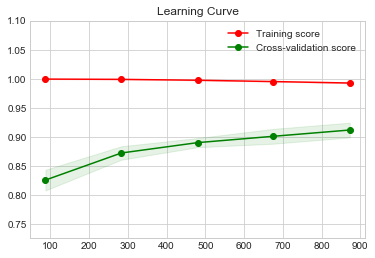

In [100]:
print(xg_reg)
plt.rcParams['figure.figsize'] = [6, 4]
train_sizes, train_scores, validation_scores = learning_curve(xg_reg, X_trainmodel,y_trainmodel.values.ravel(),cv=5)
plot_learning_curve(train_sizes, train_scores, validation_scores)

In [101]:
from mlxtend.regressor import StackingRegressor
from sklearn.linear_model import Lasso 
# best_model,xg_reg
lasso =Lasso(alpha= 0.00004,  max_iter= 10000)
stregr = StackingRegressor(regressors=[elnet_cv, xg_reg,lcv], 
                           meta_regressor=elnet_cv)

# Training the stacking classifier

stregr.fit(X_trainmodel,y_trainmodel)
 

preds = stregr.predict(X_trainmodel)
rmse = np.sqrt(mean_squared_error(y_trainmodel, preds))
print("RMSE: %f" % (rmse))
#plt.rcParams['figure.figsize'] = [6, 4]
#train_sizes, train_scores, validation_scores = learning_curve(stregr, X_trainmodel,y_trainmodel.values.ravel(),cv=5)
#plot_learning_curve(train_sizes, train_scores, validation_scores)
y_pred_val= stregr.predict(X_val)
print ("RMSLE Value :",rmsle(np.exp(y_val)-1,np.exp(y_pred_val),False))

RMSE: 0.034312
RMSLE Value : 0.11193108685296349


In [102]:
y_pred_el_result = elnet_cv.predict(X=test_X)
y_pred_stregr_result = stregr.predict(test_X)
y_pred_result =(0.80*y_pred_el_result + 0.20*y_pred_stregr_result)

In [103]:
y_pred_result = np.exp(y_pred_result)-1
print(y_pred_result[1:10])
FORMAT = '%Y%m%d%H%M%S'
timestamp=datetime.datetime.now().strftime(FORMAT)
filename ="output/submission_housing_elastic_rework"+timestamp+"_out.csv"
submission = pd.DataFrame({
        "Id": test_Id,
        "SalePrice": y_pred_result
    })
submission.to_csv(filename, index=False)


[159137.7745 182017.95   197663.9722 190192.0951 171415.5837 175849.1212
 164816.6392 186115.2579 119888.5933]


In [ ]:
[158701.691  181941.376  197336.3665 188011.7955 172906.6897 175713.6199
 166467.5227 187429.3941 119033.7805]

### Kaggle report
#### Your submission scored 0.12019, which is an improvement of your previous score of 0.12083.
####  Current place 982/4173 